In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import gym
import random

### Exercice 2.1 :
![title](img/mdp_1.png)
**1.a)** Using the previous schema, compute :

$$p(S_0|S_1,a_0)=0.7$$
$$p(S_0|S_2,a_1)=0.4$$
$$\mathbb{E}[R_t|S_{t-1}=S_1,A_{t-1}=a_0]=3.5$$
$$\mathbb{E}[R_t|S_{t-1}=S_2,A_{t-1}=a_1]=-0.3$$

**1.b)** Actions are now taken randomly : $p(a_0|S) = 1-p(a_1|S)=0.3$, compute :

$$\mathbb{E}[R_t|S_{t-1}=S_1]=1.05$$
$$\mathbb{E}[R_t|S_{t-1}=S_2]=-0.21$$

**2.)** You want an agent to learn to play this game :
<img src="img/mario.png" alt="Drawing" style="width: 300px;"/>
* How would you define a state in this game ?

**We can use the game screen (frame). Each frame is a state.**

* How many actions can you pick ?

**Up, down, right, left, jump**

* How many states are possible ?

**If the game screen is 256x240 pixels on 3 color channels, each pixel can take $256^3$ different colors. We then have $256^{3 x 256 x 240}$ different states.**

* What kind of reward function would you set ?

**The simplest reward function is to give +1 only if mario reaches the end of the level. However, since the agent needs to do a lot of exploration in this game, the probability of reaching the flag with random moves is almost $0$, it is then better to add intermediate rewards.**

**The most effective way is to use a distance : as mario always moves from left to right, we can use the distance traveled between each frame (e.g current_pos-old_pos). We can also give a reward when mario increases its score (picking coins and items or killing ennemies).**

* Can we represent the game as a finite MDP ?

**Since the number of possible states is extremely high, representing the game by a simple finite MDP isn't a good idea. Deep Q-learning can handle this kind of problem.**

### Exercice 2.2 : 
An agent moves in a grid world :
* 4 possible actions : left, up, right, down
* moving outside the grid gives $-1$ and cancels the move
* if the agent is in A, he gets $+10$ and is sent to A'
* if the agent is in B, he gets $+5$ and is sent to B'
* else moving gives $0$

<img src="img/gridworld3.jpg" alt="Drawing" style="width: 300px;"/>

* Compute value and optimal value function
* Can you infere a policy ?

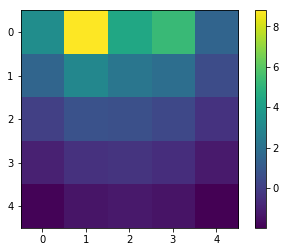

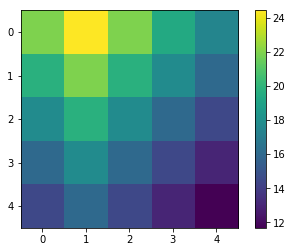

Values
 [[ 3.30903373  8.78932925  4.42765654  5.32240493  1.49221608]
 [ 1.52162547  2.99235524  2.25017731  1.90760904  0.54744003]
 [ 0.05085989  0.73820797  0.67315062  0.35822355 -0.40310382]
 [-0.97355491 -0.43545805 -0.35484491 -0.58556775 -1.18303775]
 [-1.85766316 -1.34519388 -1.2292299  -1.42288081 -1.97514172]]
Optimal values
 [[21.97744338 24.41938153 21.97744338 19.41938153 17.47744338]
 [19.77969904 21.97744338 19.77969904 17.8017056  16.02153504]
 [17.8017056  19.77969904 17.8017056  16.02153504 14.41938153]
 [16.02153504 17.8017056  16.02153504 14.41938153 12.97744338]
 [14.41938153 16.02153504 14.41938153 12.97744338 11.67969904]]
Actions
 [[2. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]]
left: 0  up : 1  right : 2  down : 3 


In [43]:
WORLD_SIZE = 5
A_POS = [0, 1]
A_PRIME_POS = [4, 1]
B_POS = [0, 3]
B_PRIME_POS = [2, 3]
DISCOUNT = 0.9

# left, up, right, down
ACTIONS = [np.array([0, -1]), #left
           np.array([-1, 0]), #up
           np.array([0, 1]), #right
           np.array([1, 0])] #down
ACTION_PROB = 0.25


def step(state, action):
    #If we are at point A or B, we are sent to A' or B', the step ends
    if state == A_POS:
        return A_PRIME_POS, 10
    if state == B_POS:
        return B_PRIME_POS, 5
    
    #Move the agent
    next_state = (np.array(state) + action).tolist()
    x, y = next_state
    
    #if we go outside the grid : -1 else 0
    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        reward = -1.0
        next_state = state
    else:
        reward = 0
    return next_state, reward


######################################
###########    POLICIES    ###########
######################################

def value_function():
    
    #<Add your code here>
    value = np.zeros((WORLD_SIZE, WORLD_SIZE))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    # bellman equation
                    new_value[i, j] += ACTION_PROB * (reward + DISCOUNT * value[next_i, next_j])
                    
        if np.sum(np.abs(value - new_value)) < 1e-4:
            plt.imshow(value);
            plt.colorbar()
            plt.show()
            break
            
        value = new_value
    return value


def optimal_value_function():
    
    #<Add your code here>
    value = np.zeros((WORLD_SIZE, WORLD_SIZE))
    arg_value = np.zeros_like(value)
    
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                values = []
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    # value iteration
                    values.append(reward + DISCOUNT * value[next_i, next_j])
                new_value[i, j] = np.max(values)
                arg_value[i, j] = np.argmax(values)
                
        if np.sum(np.abs(new_value - value)) < 1e-4:
            plt.imshow(value);
            plt.colorbar()
            plt.show()
            break
        value = new_value
    return value, arg_value


value = value_function()
optimal_value, actions = optimal_value_function()
print("Values\n", value)
print("Optimal values\n", optimal_value)
print("Actions\n", actions)
print("left: 0 ","up : 1 ","right : 2 ","down : 3 ")

### Exercice 2.3 :

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

<img src="img/Frozen-Lake.png" alt="Drawing" style="width: 300px;"/>
<img src="img/description.png" alt="Drawing" style="width: 100px;"/>

Using the gym environnement :
* Compute the optimal state value function (value_iteration function)
* Compute the optmal state-action value function (q_value function)
* Compute the optimal policy
* Why the optimal action of grid[3,2] is to go down ?

In [39]:
def value_iteration(env, nb_of_iterations=1000, gamma = 1.0, threshold=1e-20):
    
    value_table = np.zeros((env.observation_space.n))
    new_value_table = np.zeros_like(value_table)
    
    for i in range(nb_of_iterations):
        
        #TEST each state
        for state in range(env.observation_space.n):
            v_per_action = []
            
            #TEST each action
            for action in range(env.action_space.n):
                v = 0
                
                #Picking an action leads to a random new_state with a transition probability
                for _ in env.P[state][action]:
                    trans_prob, next_state, reward, done = _
                    v += trans_prob*(reward + gamma*value_table[next_state])
                    
                #v is a weighted sum (expectation)
                v_per_action.append(v)
                
            #We update by picking the action that leads to the highest expectation
            new_value_table[state] = np.max(v_per_action)
        
        if np.abs(value_table-new_value_table).sum() < threshold:
            print("Finished after %d. iterations" %(i+1))
            break
            
        value_table = new_value_table
        new_value_table = np.zeros_like(value_table)
        
    return value_table


def q_value(env, nb_of_iterations=1000, gamma = 1.0, threshold=1e-20):
 
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    new_q_table = np.zeros_like(q_table)
    
    for i in range(nb_of_iterations):
        for state in range(env.observation_space.n):
            q_per_action = []
            for action in range(env.action_space.n):
                q = 0
                for _ in env.P[state][action]:
                    trans_prob, next_state, reward, done = _
                    q += trans_prob*(reward + gamma*np.max(q_table[next_state,:]))
                q_per_action.append(q)
            new_q_table[state,:] = q_per_action
        
        if np.abs(q_table-new_q_table).sum() < threshold:
            print("Finished after %d. iterations" %(i+1))
            break
        
        q_table = new_q_table
        new_q_table = np.zeros_like(q_table)
        
    return q_table, np.argmax(q_table, axis=1)


env = gym.make('FrozenLake-v0')
env.reset()
#env.render()

optimal_value_function = value_iteration(env=env, nb_of_iterations=1000, gamma=0.95)
print("Value table\n", optimal_value_function.reshape((4,4)))

q_table, optimal_policy = q_value(env=env, nb_of_iterations=1000, gamma=0.95)
print("Q table\n", q_table) 
print("Optimal policy\n", optimal_policy.reshape((4,4)))

env.close()

Finished after 427. iterations
Value table
 [[0.18047158 0.15475672 0.15347714 0.13254844]
 [0.20896709 0.         0.17643079 0.        ]
 [0.27045741 0.37465152 0.40367272 0.        ]
 [0.         0.50897995 0.72367364 0.        ]]
Finished after 428. iterations
Q table
 [[0.18047158 0.17232854 0.17232854 0.16330496]
 [0.10615563 0.10575043 0.09760739 0.15475672]
 [0.15347714 0.14684972 0.14644452 0.13958106]
 [0.09057477 0.09057477 0.08394734 0.13254844]
 [0.20896709 0.15181776 0.14279418 0.12332225]
 [0.         0.         0.         0.        ]
 [0.17643079 0.12782969 0.17643079 0.04860109]
 [0.         0.         0.         0.        ]
 [0.15181776 0.20428449 0.18481256 0.27045741]
 [0.24682183 0.37465152 0.28900668 0.21347454]
 [0.40367272 0.34780297 0.28503307 0.1745094 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.27981663 0.3903403  0.50897995 0.34780297]
 [0.51817    0.72367364 0.69032635 0.62234001]
 [0.         0.       

### Exercice 2.4

* Compare SARSA and Q-learning on FrozenLake-v0 and Taxi-v2 environnements.
* Why training is easier on the taxi environnement ? 

For this, use the env.step(action) method :

e.g : new_state, reward, done, _ = env.step(action)

100%|████████████████████████████████████| 5000/5000 [00:04<00:00, 1126.06it/s]


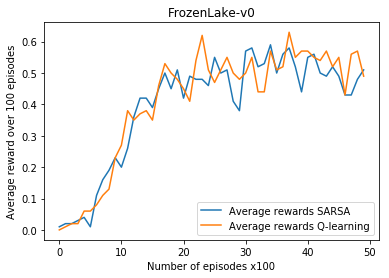

100%|████████████████████████████████████| 5000/5000 [00:04<00:00, 1186.17it/s]


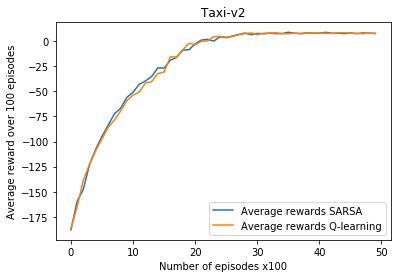

In [103]:
def train_agent(env, 
                num_episodes, 
                max_steps_per_episode, 
                algorithm, 
                lr = 0.1, 
                eps = 1, 
                discount_rate = 0.99, 
                max_eps = 1, 
                min_eps = 0.01, 
                eps_decay = 0.002):
    
    rewards_all_episodes = []
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    for episode in trange(num_episodes):

        state = env.reset()
        done = False
        rewards_current_episode = 0

        for step in range(max_steps_per_episode): 

            # Exploration-exploitation trade-off 
            if random.uniform(0, 1) > eps:
                action = np.argmax(q_table[state,:]) 
            else:
                action = env.action_space.sample()    

            #Apply action by updating the environnement
            new_state, reward, done, _ = env.step(action)
            
            if algorithm == "SARSA" and random.uniform(0, 1) < eps:
                new_action = env.action_space.sample()
            else:
                new_action = np.argmax(q_table[new_state, :])
            
            q_target = reward + discount_rate*q_table[new_state, new_action]
            
            #Apply formula
            q_table[state, action] = (1 - lr) * q_table[state, action] + lr * q_target
            
            #Update state and sum of rewards
            state = new_state
            rewards_current_episode += reward 

            if done: 
                break

        rewards_all_episodes.append(rewards_current_episode)

        # Exploration rate decay
        eps = min_eps + (max_eps - min_eps) * np.exp(-eps_decay*episode)
    
    return rewards_all_episodes
    

eps = 1
max_eps = 1
min_eps = 0.01
eps_decay = 0.002

lr = 0.1
discount_rate = 0.99

max_steps_per_episode = 50
num_episodes = 5000

envs = ['FrozenLake-v0', "Taxi-v2"]
algorithms = ["SARSA", "Q-learning"]

for env_name in envs:
    
    env = gym.make(env_name)
    all_rewards = []
    
    for algorithm in algorithms:
        rewards = train_agent(env, 
                              num_episodes, 
                              max_steps_per_episode,
                              algorithm)
        
        #Making buckets of 100 episodes
        rewards = np.stack(np.split(np.array(rewards), num_episodes/100))
        all_rewards.append(rewards)
    
    plt.plot(all_rewards[0].mean(1), label="Average rewards SARSA")
    plt.plot(all_rewards[1].mean(1), label="Average rewards Q-learning")
    plt.ylabel("Average reward over 100 episodes")
    plt.xlabel("Number of episodes x100")
    plt.legend(loc="best")
    plt.title(env_name)
    plt.show()
    
    env.close()

### Exercice 2.5

* Implement double Q-learning on FrozenLake-v0
* Is double Q-learning on or off-policy ?

100%|███████████████████████████████████| 10000/10000 [00:13<00:00, 761.17it/s]


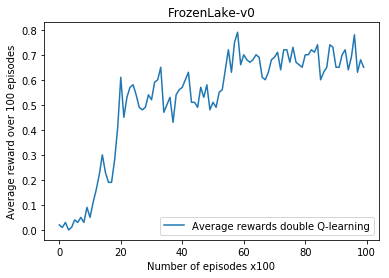

In [71]:
#Double Q learning
def train_agent(env, 
                num_episodes, 
                max_steps_per_episode,  
                lr = 0.1, 
                eps = 1, 
                discount_rate = 0.99, 
                max_eps = 1, 
                min_eps = 0.01, 
                eps_decay = 0.002):
    
    rewards_all_episodes = []
    q_table_a = np.zeros((env.observation_space.n, env.action_space.n))
    q_table_b = np.zeros_like(q_table_a)
    
    for episode in trange(num_episodes):

        state = env.reset()
        done = False
        rewards_current_episode = 0

        for step in range(max_steps_per_episode): 
            
            # Exploration-exploitation trade-off 
            if random.uniform(0, 1) > eps:
                action = np.argmax(q_table_a[state,:] + q_table_b[state,:]) 
            else:
                action = env.action_space.sample()    
            
            #Apply action by updating the environnement
            new_state, reward, done, _ = env.step(action)
            
            #Choose to update A or B
            if random.uniform(0,1) < 0.5:
                argmax = np.argmax(q_table_a[new_state, :])
                q_target = reward + discount_rate*q_table_b[new_state, argmax]
                q_table_a[state, action] = (1 - lr) * q_table_a[state, action] + lr * q_target
            else:
                argmax = np.argmax(q_table_b[new_state, :])
                q_target = reward + discount_rate*q_table_a[new_state, argmax]
                q_table_b[state, action] = (1 - lr) * q_table_b[state, action] + lr * q_target
                
                
            #Update state and sum of rewards
            state = new_state
            rewards_current_episode += reward 

            if done: 
                break

        rewards_all_episodes.append(rewards_current_episode)

        # Exploration rate decay
        eps = min_eps + (max_eps - min_eps) * np.exp(-eps_decay*episode)
    
    return rewards_all_episodes

eps = 1
max_eps = 1
min_eps = 0.01
eps_decay = 0.002

lr = 0.1
discount_rate = 0.99

max_steps_per_episode = 100
num_episodes = 10000


env = gym.make('FrozenLake-v0')
all_rewards = []

rewards = train_agent(env, num_episodes, max_steps_per_episode)
        
#Making buckets of 100 episodes
rewards = np.stack(np.split(np.array(rewards), num_episodes/100))

plt.plot(rewards.mean(1), label="Average rewards double Q-learning")
plt.ylabel("Average reward over 100 episodes")
plt.xlabel("Number of episodes x100")
plt.legend(loc="best")
plt.title('FrozenLake-v0')
plt.show()

env.close()

100%|█████████████████████████████████████| 5000/5000 [00:12<00:00, 390.57it/s]


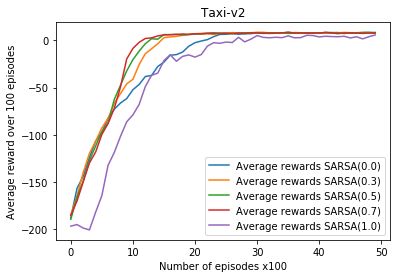

In [99]:
#SARSA LAMBDA
def train_agent(env, 
                lb,
                num_episodes, 
                max_steps_per_episode,  
                lr = 0.1, 
                eps = 1, 
                discount_rate = 0.99, 
                max_eps = 1, 
                min_eps = 0.01, 
                eps_decay = 0.002):
    
    rewards_all_episodes = []
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    for episode in trange(num_episodes):

        state = env.reset()
        done = False
        rewards_current_episode = 0
        #Trace is reset every episode
        e = np.zeros_like(q_table)
        
        for step in range(max_steps_per_episode): 
            
            q_target = np.zeros_like(q_table)
            
            # Exploration-exploitation trade-off 
            if random.uniform(0, 1) > eps:
                action = np.argmax(q_table[state,:]) 
            else:
                action = env.action_space.sample()    
            
            #Apply action by updating the environnement
            new_state, reward, done, _ = env.step(action)
            
            #Choose to update A or B
            if random.uniform(0, 1) > eps:
                new_action = np.argmax(q_table[new_state, :])
            else:
                new_action = env.action_space.sample()
                
            error = reward + discount_rate*q_table[new_state, new_action]  - q_table[state, action]
            
            #Apply formula
            e[state, action] = 1 
            
            q_table = q_table + lr * error * e
            e = e * discount_rate * lb
            
            #Update state and sum of rewards
            state = new_state
            rewards_current_episode += reward 

            if done: 
                break

        rewards_all_episodes.append(rewards_current_episode)

        # Exploration rate decay
        eps = min_eps + (max_eps - min_eps) * np.exp(-eps_decay*episode)
    
    return rewards_all_episodes

eps = 1
max_eps = 1
min_eps = 0.01
eps_decay = 0.002

lr = 0.1
discount_rate = 0.99

max_steps_per_episode = 50
num_episodes = 5000

lambdas = [0., 0.3, 0.5, 0.7, 1.]

env = gym.make('Taxi-v2')
#env = gym.make('FrozenLake-v0')
all_rewards = []

for lb in lambdas:

    rewards = train_agent(env, lb, num_episodes, max_steps_per_episode)

    #Making buckets of 100 episodes
    rewards = np.stack(np.split(np.array(rewards), num_episodes/100))
    plt.plot(rewards.mean(1), label="Average rewards SARSA("+str(lb)+")")
    
plt.ylabel("Average reward over 100 episodes")
plt.xlabel("Number of episodes x100")
plt.legend(loc="best")
plt.title('Taxi-v2')
plt.show()
env.close()